# Libraries and Global Settings

In [1]:
import pandas as pd  # work with Pandas dataframes

from keras.optimizers import Adam, RMSprop, SGD
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LeakyReLU, Bidirectional, LSTM

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, ParameterGrid

import seaborn as sns  # Visualizations
from matplotlib import pyplot as plt
%matplotlib inline

import warnings  # Funktionalität zur Unterdrückung von Warnungen
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Importing Data

Fist of all we import the data which were generated in the whole preprocess (`df_for_ML`).

In [2]:
def dateparse(x):
    return pd.datetime.strptime(x, '%Y-%m-%d')

In [3]:
df_for_ML = pd.read_csv('df_for_ML.csv',
                        parse_dates=['Datum'],
                        date_parser=dateparse)

In [4]:
df_for_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7458 entries, 0 to 7457
Data columns (total 9 columns):
Datum           7458 non-null datetime64[ns]
Temp            7458 non-null float64
WG              7458 non-null float64
WR              7458 non-null float64
Druck           7458 non-null float64
NO              7458 non-null float64
NO2             7458 non-null float64
Niederschlag    7458 non-null float64
PM10            7458 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 524.5 KB


In [5]:
df_for_ML = df_for_ML.sort_values(by=['Datum'], axis=0, ascending=True)
df_for_ML

,Datum,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10
0,2000-01-01,3.718,1.959896,234.922917,991.80,17.6266,24.236,3.5892,11.3772
1,2000-01-02,3.848,2.172912,222.511250,996.90,14.2886,28.698,3.5212,12.3972
2,2000-01-03,1.463,2.295208,220.181250,996.20,19.0638,35.336,0.8398,19.9480
3,2000-01-04,4.934,3.574979,220.885417,989.90,8.2660,24.210,1.4894,11.4780
4,2000-01-05,6.917,2.237208,220.554167,989.70,11.3496,26.208,4.3200,12.9260
...,...,...,...,...,...,...,...,...,...
7452,2020-05-27,17.300,1.700000,212.000000,1000.09,6.1000,21.700,0.0000,12.1060
7453,2020-05-28,17.300,2.400000,28.000000,996.45,4.2000,23.500,0.0000,13.9400
7454,2020-05-29,16.200,2.200000,129.000000,993.43,2.8000,18.700,0.0000,21.6300
7455,2020-05-30,15.900,2.400000,27.000000,989.46,2.4000,18.400,0.0000,13.1080


# Modeling

## Data Preparation

### Selection of Timeframe

We decided only to analyze and predict date where we have real particulates data and not derived with the KNN imputer.

In [6]:
startDate = "2003-01-01"
endDate = "2018-12-31"

In [7]:
df_for_ML = df_for_ML[(df_for_ML["Datum"] >= startDate)
                      & (df_for_ML["Datum"] <= endDate)]

In [8]:
df_for_ML.tail()

,Datum,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10
6935,2018-12-27,0.8,0.8,21.5,995.43,54.557,43.7,0.0,18.4
6936,2018-12-28,1.3,0.8,256.0,996.84,54.557,38.9,0.0,17.4
6937,2018-12-29,2.4,1.3,230.3,1000.46,11.600,28.0,0.1,11.5
6938,2018-12-30,6.5,2.1,244.0,1000.46,1.300,12.3,0.7,8.4
6939,2018-12-31,6.9,0.7,213.9,1001.15,7.600,21.6,0.9,9.3


### Split Data into Training and Validation Samples

We split the date with train data for periods 2003-2017 and test the models on data of 2017.

In [9]:
splitDate="2016-12-31"

In [10]:
df_train = df_for_ML[df_for_ML["Datum"] <= splitDate]
df_test = df_for_ML[df_for_ML["Datum"] > splitDate]

### Data Scaling and Normalization

Although we performed the outlier detection in the preprocessing we see that the rainfall has still many values outside the IQR. That is we are performing the `RobustScaler` from Sklearn which is robust to outliers.

In [11]:
df_train_woDate = df_train.drop('Datum', axis=1)
x = df_train_woDate.values  # returns a numpy array
robustScaler = RobustScaler()
x_scaled = robustScaler.fit_transform(x)
df_train_norm = pd.DataFrame(x_scaled)

In [12]:
df_train_norm.describe()

,0,1,2,3,4,5,6,7
count,5115.000000,5115.000000,5115.000000,5115.000000,5115.000000,5115.000000,5115.000000,5115.000000
mean,-0.018887,0.231913,-0.191201,-0.065132,0.318994,0.093558,1.080912,0.135750
std,0.639881,0.885091,0.706613,0.795053,0.803527,0.757731,2.315683,0.759819
min,-1.992288,-1.613262,-2.311302,-2.003989,-0.572506,-1.549712,-0.054030,-1.530163
25%,-0.523749,-0.364726,-0.685935,-0.531915,-0.296542,-0.445213,-0.054030,-0.428263
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.476251,0.635274,0.314065,0.468085,0.703458,0.554787,0.945970,0.571737
max,1.642303,3.145363,1.736575,1.917287,2.078606,2.232065,10.301666,1.922720


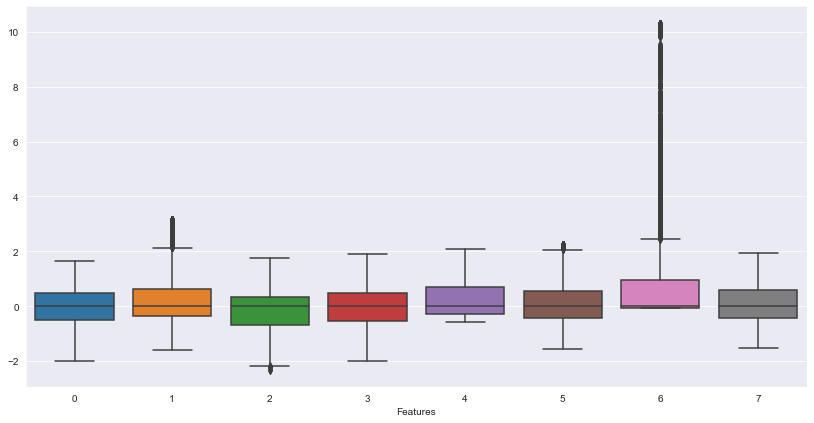

In [13]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_train_norm)
plt.xlabel("Features")
plt.show()

In [14]:
df_test_woDate = df_test.drop('Datum', axis=1)
x = df_test_woDate.values  # returns a numpy array
robustScaler = RobustScaler()
x_scaled = robustScaler.fit_transform(x)
df_test_norm = pd.DataFrame(x_scaled)

In [15]:
df_test_norm.describe()

,0,1,2,3,4,5,6,7
count,730.000000,730.000000,730.000000,7.300000e+02,730.000000,730.000000,730.000000,7.300000e+02
mean,-0.003986,0.386149,-0.546588,-3.402301e-02,0.416625,0.041931,1.232575,1.740679e-01
std,0.627787,1.006662,2.821312,8.658226e-01,1.036697,0.718378,2.632725,8.637720e-01
min,-1.623246,-1.166667,-8.774603,-2.218910e+00,-0.497132,-1.480799,0.000000,-1.443243e+00
25%,-0.490982,-0.333333,-0.369312,-4.896116e-01,-0.281071,-0.496160,0.000000,-3.908602e-01
50%,0.000000,0.000000,0.000000,6.846520e-15,0.000000,0.000000,0.000000,-9.649399e-17
75%,0.509018,0.666667,0.630688,5.103884e-01,0.718929,0.503840,1.000000,6.091398e-01
max,1.294589,4.777674,6.069841,2.220717e+00,3.667839,2.741997,11.500000,2.828963e+00


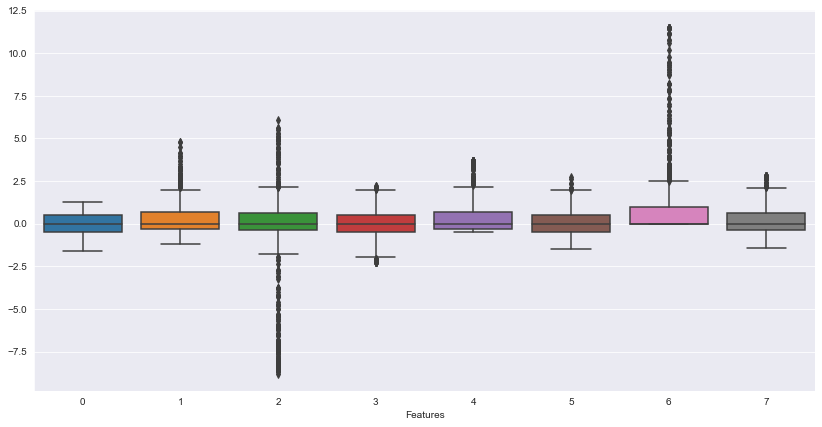

In [16]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_test_norm)
plt.xlabel("Features")
plt.show()

Now we want to return the column names.

In [17]:
i = 0
dictColumn = {}
for i in range(0, (len(df_test_woDate.columns))):
    dictColumn.update(
        {list(df_test_norm.columns)[i]: list(df_test_woDate.columns)[i]})
    i = i + 1
dictColumn

{0: 'Temp',
 1: 'WG',
 2: 'WR',
 3: 'Druck',
 4: 'NO',
 5: 'NO2',
 6: 'Niederschlag',
 7: 'PM10'}

In [18]:
df_train_norm=df_train_norm.rename(columns=dictColumn)
df_test_norm=df_test_norm.rename(columns=dictColumn)

In [19]:
df_train_norm.head()

,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10
0,-0.497606,0.534182,-0.842573,-0.968085,0.854268,-0.388466,0.522287,1.922720
1,-0.030507,2.803730,0.278038,-2.003989,-0.184573,-0.494118,10.301666,-1.098083
2,-0.285835,2.748578,0.298085,-1.904255,-0.096081,-0.384314,1.062584,-0.189196
3,-0.571840,-0.313689,-0.032778,-1.776596,0.474810,0.054902,10.301666,-0.663016
4,-1.144782,0.016070,-0.603272,-0.968085,0.228162,-0.303114,0.234129,-0.073853


### Split Data into Input and Target Data

Define the funktion to generate featuers and target data on basis of train and test requirements.

In [20]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        targets = y.iloc[i + time_steps]
        Xs.append(v)
        ys.append(targets)
    return np.array(Xs), np.array(ys)

#### Split Data into Input and Target Data for Neural Networks

On basis of the last three weeks we want to predict the target value for particulate.

In [21]:
TIME_STEPS = 21
STEP = 1

X_train, y_train = create_dataset(
    # df_train.drop(columns=['PM10']),
    df_train_norm,
    df_train_norm.PM10,
    TIME_STEPS,
    STEP)

X_test, y_test = create_dataset(
    # df_test.drop(columns=['PM10']),
    df_test_norm,
    df_test_norm.PM10,
    TIME_STEPS,
    STEP)

#### Split Data into Input and Target Data for Baseline Model

On basis of the last day we want to predict the target value for particulate.

In [141]:
TIME_STEPS = 1
STEP = 1

X_train_base, y_train_base = create_dataset(
    # df_train.drop(columns=['PM10']),
    df_train_norm,
    df_train_norm.PM10,
    TIME_STEPS,
    STEP)

X_test_base, y_test_base = create_dataset(
    # df_test.drop(columns=['PM10']),
    df_test_norm,
    df_test_norm.PM10,
    TIME_STEPS,
    STEP)

## Alogrithms Selection

As a simple base line model, we opted for a linear regression that predicts the value of the particulates based on the features including the particulates of the previous day. 

For the final model, we opted for an LSTM neural network that predicts the value of particulate based on the features including the particulates of the previous 21 days. LSTM is traditionaly one of the best approach method for times series forcasting.

## Baseline Models

At this point we have to reshape the given features numpay arrey in a compatible shape for the baseline model `linear regression`.

In [142]:
X_train_base = X_train_base.reshape(-1,8) 
X_test_base = X_test_base.reshape(-1,8)

In [143]:
#X_train_base.shape 
#y_train_base.shape
#X_test_base.shape
#y_test_base.shape

Print the second datarow to compare the value of particulate with the first data row in the `y_train` data set!

In [144]:
X_train_base[1]

array([-0.03050718,  2.8037301 ,  0.27803752, -2.00398936, -0.18457257,
       -0.49411765, 10.30166592, -1.09808315])

First data row in the `y_train` data set.

In [145]:
y_train_base[0]

-1.098083146626836

In [146]:
# Create linear regression object
regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_train_base, y_train_base)

LinearRegression()

In [147]:
test_pred = regr.predict(X_test_base)

In [148]:
y_test_base[0:10]

array([ 0.23039722, -0.84551432, -1.44324295, -0.03042982, -0.53034831,
        0.86072923, -0.12823996, -0.54121611, -0.26952127, -1.34543281])

In [149]:
test_pred[0:10]

array([ 1.52565211, -0.1833968 , -0.35470202, -1.31773741,  0.96428124,
       -0.0948241 ,  1.43278755,  0.82098009, -0.10044902,  0.71482584])

In [150]:
print("Coeffs: ", regr.coef_)

print("Intercept: ", regr.intercept_)

print("R2: ", regr.score(X_test_base, y_test_base))

print("MSE: ", mean_squared_error(y_test_base, test_pred))

Coeffs:  [-0.10414092 -0.04563868 -0.11416187  0.08072053 -0.08832656  0.08064271
 -0.01170564  0.57468738]
Intercept:  0.08297945185226491
R2:  0.3635360430729061
MSE:  0.4687049200906185


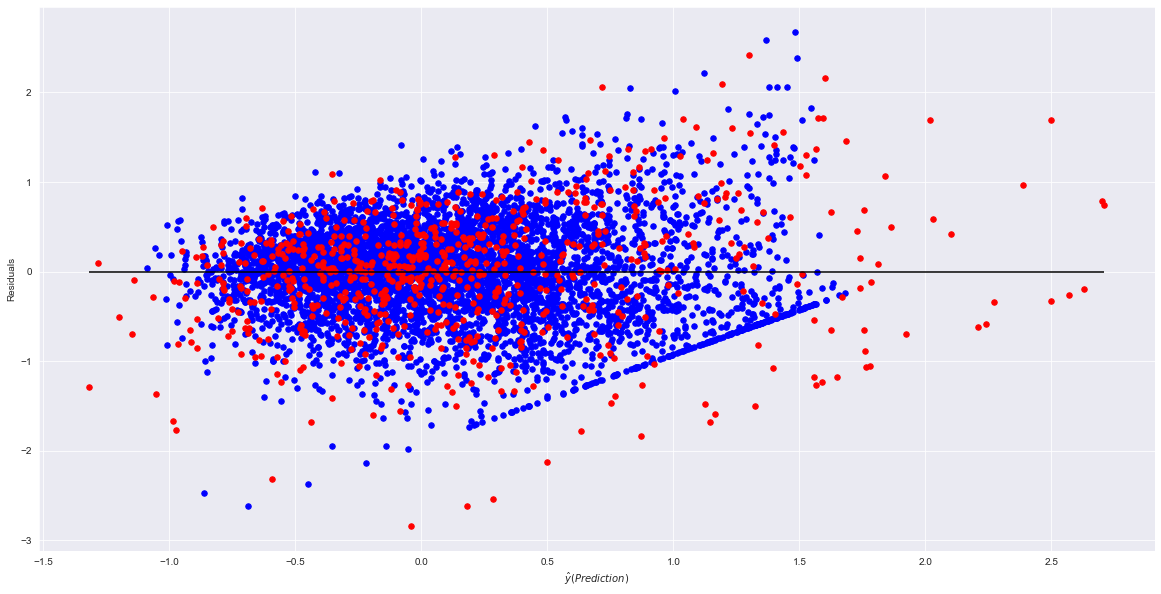

In [151]:
# Residual Plot (Restwert)
train_pred = regr.predict(X_train_base)
test_pred = regr.predict(X_test_base)

min_val = min(min(train_pred), min(test_pred))
max_val = max(max(train_pred), max(test_pred))


plt.figure(figsize=(20,10))
plt.scatter(train_pred, train_pred - y_train_base, color="blue", s=30)
plt.scatter(test_pred, test_pred - y_test_base, color="red", s=30)
plt.hlines(y = 0, xmin =min_val, xmax=max_val)
plt.xlabel("$\hat{y} (Prediction)$")
plt.ylabel("Residuals")
plt.show()

> **Result documentation baseline model:**<br>
The standard deviation of our test dataset is 0.864, the variance is 0.746. The variance is the value that we want to beat with our prediction models. 
We determine for each model the mean squared error (MSE) which will be used to compare with the variance value as benchmark. 
The Baseline Model shows a MSE of 0.469 which is already better then the variance.


## Deep Learning Models

### Vanilla Model

In [152]:
vanilla_model = Sequential()
vanilla_model.add(
    layers.LSTM(units=200,
                return_sequences=False,
                #activation='tanh',
                input_shape=(X_train.shape[1], X_train.shape[2])))
vanilla_model.add(layers.Dense(1))
vanilla_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 200)               167200    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 167,401
Trainable params: 167,401
Non-trainable params: 0
_________________________________________________________________


In [153]:
vanilla_model.compile(optimizer='RMSprop', loss='mse')
vanilla_history = vanilla_model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_test, y_test))

Train on 5094 samples, validate on 709 samples
Epoch 1/10
5094/5094 [==============================] - 13s 3ms/step - loss: 0.3192 - val_loss: 0.5598
Epoch 2/10
5094/5094 [==============================] - 12s 2ms/step - loss: 0.2768 - val_loss: 0.4965
Epoch 3/10
5094/5094 [==============================] - 11s 2ms/step - loss: 0.2709 - val_loss: 0.4211- ETA: 0s - loss: 0.
Epoch 4/10
5094/5094 [==============================] - 11s 2ms/step - loss: 0.2660 - val_loss: 0.4894
Epoch 5/10
5094/5094 [==============================] - 12s 2ms/step - loss: 0.2611 - val_loss: 0.4843
Epoch 6/10
5094/5094 [==============================] - 13s 3ms/step - loss: 0.2602 - val_loss: 0.4486
Epoch 7/10
5094/5094 [==============================] - 12s 2ms/step - loss: 0.2562 - val_loss: 0.4705
Epoch 8/10
5094/5094 [==============================] - 11s 2ms/step - loss: 0.2510 - val_loss: 0.4439
Epoch 9/10
5094/5094 [==============================] - 12s 2ms/step - loss: 0.2467 - val_loss: 0.4743
Epoch 

In [154]:
print("Minimum validation loss: ", min(vanilla_history.history['val_loss']))

Minimum validation loss:  0.4210532826748486


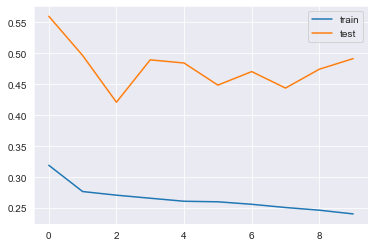

In [155]:
plt.plot(vanilla_history.history['loss'], label='train')
plt.plot(vanilla_history.history['val_loss'], label='test')
plt.legend()
plt.show()

> **Result documentation Vanilla LSTM model:**<br>
The Vanilla LSTM model shows the min MSE of 0.421 which is better than the variance of our testdata (benchmark) and our Baseline model.

### Manual Model Optimaziation

Based on the Vanilla LSTM model we manually develop an better model with the help of a trial and error principle. 

In [210]:
model = Sequential()
model.add(LSTM(units=20, activation = 'sigmoid', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 20)                2320      
_________________________________________________________________
dropout_30 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 21        
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
_________________________________________________________________


In [211]:
model.compile(optimizer='RMSprop', loss='mse')
history = model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_test, y_test))

Train on 5094 samples, validate on 709 samples
Epoch 1/50
5094/5094 [==============================] - 3s 520us/step - loss: 0.4905 - val_loss: 0.5426
Epoch 2/50
5094/5094 [==============================] - 3s 494us/step - loss: 0.3813 - val_loss: 0.5060
Epoch 3/50
5094/5094 [==============================] - 2s 425us/step - loss: 0.3521 - val_loss: 0.4905
Epoch 4/50
5094/5094 [==============================] - 2s 402us/step - loss: 0.3373 - val_loss: 0.4867
Epoch 5/50
5094/5094 [==============================] - 3s 507us/step - loss: 0.3282 - val_loss: 0.4783
Epoch 6/50
5094/5094 [==============================] - 2s 426us/step - loss: 0.3138 - val_loss: 0.4698
Epoch 7/50
5094/5094 [==============================] - 2s 443us/step - loss: 0.3079 - val_loss: 0.4637
Epoch 8/50
5094/5094 [==============================] - 2s 425us/step - loss: 0.3090 - val_loss: 0.4533
Epoch 9/50
5094/5094 [==============================] - 3s 501us/step - loss: 0.3087 - val_loss: 0.4480
Epoch 10/50
5094/

In [22]:
print("Minimum validation loss: ", min(history.history['val_loss']))
print("Difference between min Loss and min val_loss: ", min(history.history['val_loss'])-min(history.history['loss']))

NameError: name 'history' is not defined

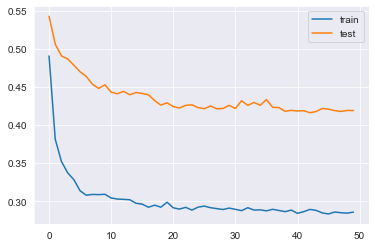

In [213]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Following `optimization steps` are done.  

-----

`Step 1:` ***Number of units for LSTM layer***  

- 50 (min val_loss = 0.418)
- 20 (min val_loss = 0.392)
- 10 (min val_loss = 0.391)
- 5 (min val_loss = 0.410)
- 75 (min val_loss = 0.427)
- 100 (min val_loss = 0.424)
- 120 (min val_loss = 0.437)

*Results:* 

The multiple training with a specific unit amount varies because the initialization values are different each time.  
Anyway we see that a smaller amount of units performs better than a too large amount. 
> We decided to use the unit number ***20***.

-----

`Step 2:` ***Activation function***  

- tanh(min val_loss = 0.392)
- linear (min val_loss = 0.482)
- sigmoid (min val_loss = 0.411)
- relu (min val_loss = 0.488)
- leaky relu (alpha = 0.3) / implemented as an additional layer (min val_loss = 0.413)
- softplus (min val_loss = 0.408)
- selu (min val_loss = 0.467)
- elu (min val_loss = 0.598)

The exponential function does not work in our model (validatons are shown as NaNs).  

The softmax function is a more generalized logistic activation function which is used for multiclass classification.

As the sigmoid and the tanh functions are close we extended the validation with epochs number of 50 for both to get a better picture.  
- sigmoid (min val_loss = 0.384) with epochs = 18
- tanh(min val_loss = 0.407)

*Results:* 

The multiple training with a specific unit amount varies because the initialization values are different each time.  
Anyway we see that a smaller amount of units performs better than a too large amount. 

> We decided to use the ***Sigmoid*** function.

-----

`Step 3:` ***Batch Sizes***  

- 500 (min val_loss = 0.548)
- 100 (min val_loss=0.417)
- 10 (min val_loss=0.405)

*Results:* 

Changing the batch sizes does not improve the results, so we decide to use the default value.
> We decided to use the ***default*** value

-----

`Step 4:` ***Additional Layers***  

- 1 additional dropout layer with 20 % (min val_loss = 0.437)
The difference between the train and val losses decreased significantly (0.139). 
- 1 additional dropout layer with 30 % (min val_loss = 0.442)
The difference between the train and val losses is 0.139. 
- 1 additional dropout layer with 40 % (min val_loss = 0.452)
The difference between the train and val losses decreased again better than in the vanilla model (0.137). 

> We decided to use ***Dropout*** with 30 %.

- 1 standalone GRU layer as input layer (min val_loss = 0.448)
No improvment.

- 1 additional LSTM layer (min val_loss = 0.464, difference between loss and val_loss = 0.148)

- 1 additional SimpleRNN layer (min val_loss = 0.491, difference between loss and val_loss = 0.168)

- 1 Additional LSTM layser and the input LSTM is a bidirectional (min val_loss = 0.4529

- 4 Additional LSTM layserS (min val_loss = 0.429, difference between loss and val_loss = 0.118)

*Results:* 

Additional layers do not lead to an improvement of the results. 
Anyway the dropout layer makes sense to generalize the model. 

> We decided to use ***Vanilla LSTM model with Dropout layer***.

-----



### Hyperparameters Optimization 

In [31]:
def model_fnReg(optimizer, learning_rate):
    
    model = Sequential()
    model.add(LSTM(units=20, activation = 'sigmoid', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(layers.Dense(1))
    
    opt = optimizer(learning_rate=learning_rate)
    model.compile(loss='mse',
                 optimizer=opt 
                 )
    
    return model

In [32]:
# Definition konstanter Parameter
epochs = 20

optimizer_candidates = [Adam, 
                        #RMSprop, 
                        #SGD
                       ]
lr_candidates = [1e-3, 
                 5e-3, 
                 #5e-2, 
                 #1e-2, 
                 #1e-4
                ]

for i in optimizer_candidates:
    # rint(i)
    for j in lr_candidates:
        print('Optimizer: ', i, ' Learningrate: ', j)
        model = model_fnReg(i, j)
        history = model.fit(x=X_train,
                            y=y_train,
                            epochs=epochs,
                            validation_data=(X_test, y_test))
        print("Minimum validation loss: ", min(history.history['val_loss']))
        print("Difference between min Loss and min val_loss: ",
              min(history.history['val_loss']) - min(history.history['loss']))

Optimizer:  <class 'keras.optimizers.Adam'>  Learningrate:  0.001
Train on 5094 samples, validate on 709 samples
Epoch 1/20
5094/5094 [==============================] - 4s 751us/step - loss: 0.5097 - val_loss: 0.5721
Epoch 2/20
5094/5094 [==============================] - 3s 530us/step - loss: 0.4028 - val_loss: 0.5402
Epoch 3/20
5094/5094 [==============================] - 3s 510us/step - loss: 0.3680 - val_loss: 0.5246
Epoch 4/20
5094/5094 [==============================] - 3s 520us/step - loss: 0.3485 - val_loss: 0.5072
Epoch 5/20
5094/5094 [==============================] - 2s 490us/step - loss: 0.3379 - val_loss: 0.4988
Epoch 6/20
5094/5094 [==============================] - 3s 528us/step - loss: 0.3300 - val_loss: 0.4884
Epoch 7/20
5094/5094 [==============================] - 3s 501us/step - loss: 0.3246 - val_loss: 0.4836
Epoch 8/20
5094/5094 [==============================] - 3s 492us/step - loss: 0.3157 - val_loss: 0.4787
Epoch 9/20
5094/5094 [==============================] -

In [217]:
# Definition konstanter Parameter
epochs = 20
batch_size = 32

# Defonition variabler Parameter
optimizer_candidates = [Adam, RMSprop, SGD]
lr_candidates = [1e-3, 5e-3, 5e-2, 1e-2, 1e-4]

# Definition Dictionary mit Parameter für die Erzeugung des Parametergrid
param_grid = {
    "optimizer": optimizer_candidates,
    "learning_rate": lr_candidates,
}

# Erzeugung des Parametergrid-Objektes zur Darstellung der Kombinationen
grid = ParameterGrid(param_grid)
for comb in grid:
    print(comb)

# Erzeugung des KerasClassifier-Objektes
keras_reg = KerasRegressor(build_fn=model_fnReg,
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)

# Erzeugung des GridSearchCV-Objektes
grid_cv = GridSearchCV(estimator=keras_reg,
                       param_grid=param_grid,
                       n_jobs=1,
                       verbose=0,
                       cv=3)

# Trenieren des Gridmodells
grid_result = grid_cv.fit(X_train, y_train)

print("Minimum validation loss: ", min(grid_result.history['val_loss']))

# Ausgabe der Werte
print("Best: %f using %s" %
      (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]

for mean, std, param in zip(means, stds, params):
    print("Acc: %f (+/- %f) with: %r" % (mean, std, param))

{'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.Adam'>}
{'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.RMSprop'>}
{'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.SGD'>}
{'learning_rate': 0.005, 'optimizer': <class 'keras.optimizers.Adam'>}
{'learning_rate': 0.005, 'optimizer': <class 'keras.optimizers.RMSprop'>}
{'learning_rate': 0.005, 'optimizer': <class 'keras.optimizers.SGD'>}
{'learning_rate': 0.05, 'optimizer': <class 'keras.optimizers.Adam'>}
{'learning_rate': 0.05, 'optimizer': <class 'keras.optimizers.RMSprop'>}
{'learning_rate': 0.05, 'optimizer': <class 'keras.optimizers.SGD'>}
{'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>}
{'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.RMSprop'>}
{'learning_rate': 0.01, 'optimizer': <class 'keras.optimizers.SGD'>}
{'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizers.Adam'>}
{'learning_rate': 0.0001, 'optimizer': <class 'keras.optimizers.RMSprop'>}

AttributeError: 'GridSearchCV' object has no attribute 'history'

## Evaluation

### Model Evaluation (Performance)

#### Training Phase

#### Testing Phase

# Projekt Evaluation

# Deployment

In the first phase of CRISP the overall business-case, which shall be supported by the data mining process must be clearly defined and understood. Then the goal of the data mining project itself must be defined. This includes the specification of metrics for measuring the performance of the data mining project.

In the second phase data must be gathered, accessed, understood and described. Quantitiy and qualitity of the data must be assessed on a high-level.

In the third phase data must be investigated and understood more thoroughly. Common means for understanding data are e.g. visualization and the calculation of simple statistics. Outliers must be detected and processed, sampling rates must be determined, features must be selected and eventually be transformed to other formats.

In the modelling phase various algorithms and their hyperparameters are selected and applied. Their performance on the given data is determined in the evaluation phase.

The output of the evaluation is usually fed back to the first phases (business- and data-understanding). Applying this feedback the techniques in the overall process are adapted and optimized. Usually only after several iterations of this process the evaluation yields good results and the project can be deployed.